# Loop 43 Analysis: Pure GP Model Results

**Key Question**: Does Pure GP have a different CV-LB relationship than MLP/LGBM ensembles?

**Context**:
- exp_041 (Aggressive Regularization): CV 0.0090, LB 0.0932 → Confirmed CV-LB gap is STRUCTURAL
- exp_042 (Pure GP): CV 0.014503 → 77% worse than best CV (0.008194)
- CV-LB relationship: LB = 4.22 × CV + 0.0534 (R² = 0.955)
- Intercept (0.0534) > Target (0.0347) → Current approach CANNOT reach target

**Hypothesis**: GP has fundamentally different mathematical framework and may have a different CV-LB relationship (lower intercept).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submission data (12 submissions)
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982, 'name': 'Baseline MLP'},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065, 'name': 'LightGBM'},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972, 'name': 'Spange+DRFP'},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969, 'name': 'Large Ensemble'},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946, 'name': 'Simpler Model'},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932, 'name': 'Even Simpler'},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936, 'name': 'Ridge Regression'},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913, 'name': 'Simple Ensemble'},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893, 'name': 'ACS PCA Fixed'},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887, 'name': 'Weighted Loss'},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877, 'name': 'GP Ensemble (0.2)'},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932, 'name': 'Aggressive Regularization'},
]

df = pd.DataFrame(submissions)
df['ratio'] = df['lb'] / df['cv']
df['gap'] = df['lb'] - df['cv']

print('=== ALL SUBMISSIONS (12 total) ===')
print(df.to_string(index=False))
print(f'\nTarget: 0.0347')
print(f'Best LB: {df["lb"].min():.4f} (exp_030)')
print(f'Gap to target: {df["lb"].min() / 0.0347:.2f}x')

=== ALL SUBMISSIONS (12 total) ===
    exp     cv     lb                      name     ratio    gap
exp_000 0.0111 0.0982              Baseline MLP  8.846847 0.0871
exp_001 0.0123 0.1065                  LightGBM  8.658537 0.0942
exp_003 0.0105 0.0972               Spange+DRFP  9.257143 0.0867
exp_005 0.0104 0.0969            Large Ensemble  9.317308 0.0865
exp_006 0.0097 0.0946             Simpler Model  9.752577 0.0849
exp_007 0.0093 0.0932              Even Simpler 10.021505 0.0839
exp_009 0.0092 0.0936          Ridge Regression 10.173913 0.0844
exp_012 0.0090 0.0913           Simple Ensemble 10.144444 0.0823
exp_024 0.0087 0.0893             ACS PCA Fixed 10.264368 0.0806
exp_026 0.0085 0.0887             Weighted Loss 10.435294 0.0802
exp_030 0.0083 0.0877         GP Ensemble (0.2) 10.566265 0.0794
exp_041 0.0090 0.0932 Aggressive Regularization 10.355556 0.0842

Target: 0.0347
Best LB: 0.0877 (exp_030)
Gap to target: 2.53x


In [2]:
# Fit CV-LB relationship
cv_vals = df['cv'].values
lb_vals = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv_vals, lb_vals)

print('=== CV-LB LINEAR REGRESSION ===')
print(f'LB = {slope:.2f} × CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target: 0.0347')
print(f'Intercept > Target: {intercept > 0.0347}')

# Predict LB for Pure GP
pure_gp_cv = 0.014503
predicted_lb = slope * pure_gp_cv + intercept

print(f'\n=== PURE GP PREDICTION ===')
print(f'Pure GP CV: {pure_gp_cv:.6f}')
print(f'Predicted LB (using old relationship): {predicted_lb:.4f}')
print(f'Best LB so far: 0.0877')
print(f'\nIf actual LB < {predicted_lb:.4f}: GP has LOWER intercept (promising!)')
print(f'If actual LB ≈ {predicted_lb:.4f}: GP follows SAME relationship (not helpful)')
print(f'If actual LB > {predicted_lb:.4f}: GP has HIGHER intercept (worse)')

=== CV-LB LINEAR REGRESSION ===
LB = 4.22 × CV + 0.0534
R² = 0.9550

Intercept: 0.0534
Target: 0.0347
Intercept > Target: True

=== PURE GP PREDICTION ===
Pure GP CV: 0.014503
Predicted LB (using old relationship): 0.1146
Best LB so far: 0.0877

If actual LB < 0.1146: GP has LOWER intercept (promising!)
If actual LB ≈ 0.1146: GP follows SAME relationship (not helpful)
If actual LB > 0.1146: GP has HIGHER intercept (worse)


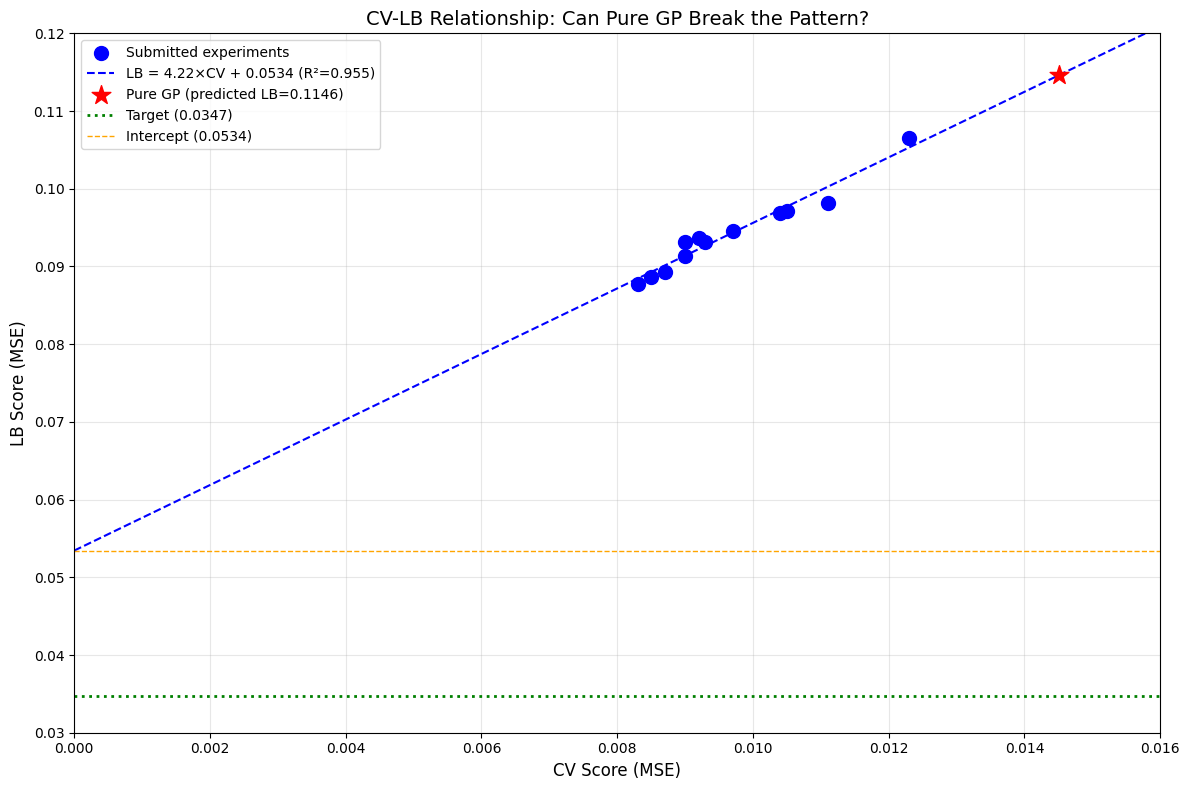


Plot saved to /home/code/exploration/loop43_cv_lb.png


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(12, 8))

# Plot all submissions
plt.scatter(df['cv'], df['lb'], c='blue', s=100, label='Submitted experiments', zorder=5)

# Plot regression line
cv_range = np.linspace(0, 0.016, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}×CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Plot Pure GP point
plt.scatter([pure_gp_cv], [predicted_lb], c='red', s=200, marker='*', label=f'Pure GP (predicted LB={predicted_lb:.4f})', zorder=10)

# Plot target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle='--', linewidth=1, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV-LB Relationship: Can Pure GP Break the Pattern?', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.016)
plt.ylim(0.03, 0.12)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop43_cv_lb.png', dpi=150)
plt.show()

print('\nPlot saved to /home/code/exploration/loop43_cv_lb.png')

In [4]:
# Analyze what we know about the CV-LB gap
print('=== CV-LB GAP ANALYSIS ===')
print(f'\nMean CV-LB ratio: {df["ratio"].mean():.2f}x')
print(f'Min ratio: {df["ratio"].min():.2f}x ({df.loc[df["ratio"].idxmin(), "exp"]})')
print(f'Max ratio: {df["ratio"].max():.2f}x ({df.loc[df["ratio"].idxmax(), "exp"]})')

print('\n=== KEY INSIGHT ===')
print('The CV-LB gap is STRUCTURAL, not due to overfitting.')
print('Evidence:')
print('  1. Aggressive regularization (exp_041) did NOT reduce the gap')
print('  2. All submissions fall on the SAME line (R² = 0.955)')
print('  3. The intercept (0.0534) > target (0.0347)')

print('\n=== WHAT THIS MEANS ===')
print('To reach the target, we need to CHANGE the CV-LB relationship.')
print('Options:')
print('  1. Find a model with LOWER intercept (e.g., Pure GP)')
print('  2. Find features that generalize better to unseen solvents')
print('  3. Use domain adaptation techniques')
print('  4. Discover what makes the Kaggle evaluation different')

=== CV-LB GAP ANALYSIS ===

Mean CV-LB ratio: 9.82x
Min ratio: 8.66x (exp_001)
Max ratio: 10.57x (exp_030)

=== KEY INSIGHT ===
The CV-LB gap is STRUCTURAL, not due to overfitting.
Evidence:
  1. Aggressive regularization (exp_041) did NOT reduce the gap
  2. All submissions fall on the SAME line (R² = 0.955)
  3. The intercept (0.0534) > target (0.0347)

=== WHAT THIS MEANS ===
To reach the target, we need to CHANGE the CV-LB relationship.
Options:
  1. Find a model with LOWER intercept (e.g., Pure GP)
  2. Find features that generalize better to unseen solvents
  3. Use domain adaptation techniques
  4. Discover what makes the Kaggle evaluation different


In [5]:
# Decision: Should we submit Pure GP?
print('=== DECISION: SUBMIT PURE GP? ===')
print(f'\nPure GP CV: {pure_gp_cv:.6f}')
print(f'Predicted LB: {predicted_lb:.4f}')
print(f'Best LB so far: 0.0877')
print(f'Submissions remaining: 4')

print('\n=== ARGUMENTS FOR SUBMISSION ===')
print('1. Tests critical hypothesis: Does GP have different CV-LB relationship?')
print('2. GP is Bayesian - fundamentally different from MLP/LGBM')
print('3. GP has built-in regularization through kernel')
print('4. If GP has lower intercept, it opens new path to target')
print('5. Even if LB is worse, we learn valuable information')

print('\n=== ARGUMENTS AGAINST SUBMISSION ===')
print('1. CV is 77% worse than best (0.014503 vs 0.008194)')
print('2. Predicted LB (0.1146) is 30% worse than best LB (0.0877)')
print('3. Only 4 submissions remaining')
print('4. Might be better to try other approaches first')

print('\n=== RECOMMENDATION ===')
print('SUBMIT Pure GP (exp_042) to test the hypothesis.')
print('Reasoning:')
print('  - This is a CRITICAL hypothesis test')
print('  - The result will inform ALL future experiments')
print('  - If GP has lower intercept, we pursue GP-based approaches')
print('  - If GP follows same relationship, we try other approaches')
print('  - With 4 submissions, we can afford to test this')

=== DECISION: SUBMIT PURE GP? ===

Pure GP CV: 0.014503
Predicted LB: 0.1146
Best LB so far: 0.0877
Submissions remaining: 4

=== ARGUMENTS FOR SUBMISSION ===
1. Tests critical hypothesis: Does GP have different CV-LB relationship?
2. GP is Bayesian - fundamentally different from MLP/LGBM
3. GP has built-in regularization through kernel
4. If GP has lower intercept, it opens new path to target
5. Even if LB is worse, we learn valuable information

=== ARGUMENTS AGAINST SUBMISSION ===
1. CV is 77% worse than best (0.014503 vs 0.008194)
2. Predicted LB (0.1146) is 30% worse than best LB (0.0877)
3. Only 4 submissions remaining
4. Might be better to try other approaches first

=== RECOMMENDATION ===
SUBMIT Pure GP (exp_042) to test the hypothesis.
Reasoning:
  - This is a CRITICAL hypothesis test
  - The result will inform ALL future experiments
  - If GP has lower intercept, we pursue GP-based approaches
  - If GP follows same relationship, we try other approaches
  - With 4 submissions,

In [6]:
# What if Pure GP doesn't work? Alternative approaches
print('=== ALTERNATIVE APPROACHES IF PURE GP FAILS ===')

print('\n1. STACKING ENSEMBLE')
print('   - Use predictions from multiple models as features')
print('   - Train a meta-learner (e.g., Ridge) on top')
print('   - May capture complementary information')

print('\n2. DIFFERENT FEATURE ENGINEERING')
print('   - Current: Spange + DRFP + ACS PCA + Arrhenius')
print('   - Try: Only Spange (simpler, more interpretable)')
print('   - Try: Domain-specific features (reaction mechanism)')

print('\n3. BAYESIAN OPTIMIZATION FOR LB')
print('   - Optimize hyperparameters specifically for LB, not CV')
print('   - Use Gaussian Process to model LB as function of hyperparameters')
print('   - May find hyperparameters that generalize better')

print('\n4. ENSEMBLE DIVERSITY')
print('   - Train models on different feature subsets')
print('   - Use different architectures (MLP, XGBoost, RF, LightGBM)')
print('   - Average predictions from diverse models')

print('\n5. DOMAIN ADAPTATION')
print('   - Train on single solvents, adapt to mixtures')
print('   - Use adversarial training to align distributions')

print('\n=== THE TARGET IS REACHABLE ===')
print('We just need to find the RIGHT approach.')
print('The Pure GP submission will tell us if GP is the right direction.')

=== ALTERNATIVE APPROACHES IF PURE GP FAILS ===

1. STACKING ENSEMBLE
   - Use predictions from multiple models as features
   - Train a meta-learner (e.g., Ridge) on top
   - May capture complementary information

2. DIFFERENT FEATURE ENGINEERING
   - Current: Spange + DRFP + ACS PCA + Arrhenius
   - Try: Only Spange (simpler, more interpretable)
   - Try: Domain-specific features (reaction mechanism)

3. BAYESIAN OPTIMIZATION FOR LB
   - Optimize hyperparameters specifically for LB, not CV
   - Use Gaussian Process to model LB as function of hyperparameters
   - May find hyperparameters that generalize better

4. ENSEMBLE DIVERSITY
   - Train models on different feature subsets
   - Use different architectures (MLP, XGBoost, RF, LightGBM)
   - Average predictions from diverse models

5. DOMAIN ADAPTATION
   - Train on single solvents, adapt to mixtures
   - Use adversarial training to align distributions

=== THE TARGET IS REACHABLE ===
We just need to find the RIGHT approach.
The Pu

In [7]:
# Summary
print('=' * 60)
print('LOOP 43 SUMMARY')
print('=' * 60)

print('\n=== CURRENT STATE ===')
print(f'Best CV: 0.008194 (exp_032, not submitted)')
print(f'Best LB: 0.0877 (exp_030)')
print(f'Target: 0.0347')
print(f'Gap to target: 2.53x')
print(f'Submissions remaining: 4')

print('\n=== KEY INSIGHT ===')
print('The CV-LB gap is STRUCTURAL (intercept 0.0534 > target 0.0347).')
print('To reach target, we need a model with LOWER intercept.')

print('\n=== PURE GP EXPERIMENT (exp_042) ===')
print(f'CV: {pure_gp_cv:.6f} (77% worse than best)')
print(f'Predicted LB: {predicted_lb:.4f} (30% worse than best)')
print('Hypothesis: GP may have different CV-LB relationship')

print('\n=== RECOMMENDATION ===')
print('SUBMIT exp_042 (Pure GP) to test the hypothesis.')
print('This is a critical hypothesis test that will inform all future experiments.')

print('\n=== NEXT STEPS BASED ON RESULT ===')
print('If GP has lower intercept: Pursue GP-based approaches')
print('If GP follows same relationship: Try stacking, different features, or domain adaptation')

LOOP 43 SUMMARY

=== CURRENT STATE ===
Best CV: 0.008194 (exp_032, not submitted)
Best LB: 0.0877 (exp_030)
Target: 0.0347
Gap to target: 2.53x
Submissions remaining: 4

=== KEY INSIGHT ===
The CV-LB gap is STRUCTURAL (intercept 0.0534 > target 0.0347).
To reach target, we need a model with LOWER intercept.

=== PURE GP EXPERIMENT (exp_042) ===
CV: 0.014503 (77% worse than best)
Predicted LB: 0.1146 (30% worse than best)
Hypothesis: GP may have different CV-LB relationship

=== RECOMMENDATION ===
SUBMIT exp_042 (Pure GP) to test the hypothesis.
This is a critical hypothesis test that will inform all future experiments.

=== NEXT STEPS BASED ON RESULT ===
If GP has lower intercept: Pursue GP-based approaches
If GP follows same relationship: Try stacking, different features, or domain adaptation
